![alt text](code/afni-preprocessing.png "AFNI Recommended Preprocessing Steps")


1. From SAPIENT ME-ICA-no-gs (documentations: http://sapient.mssm.edu/documentation/pipes/ME-ICA-no-gs.html), use `sapient_T1c_medn_nat.nii.gz` (Denoised timeseries with T1 equilibration correction - including thermal noise - in native space) to get acompcor regressors, but then use `nlw` (template space for all analysis)
2. Get acompcor timeseries: Use CONN to do segmentation + getting the acompcor regressors (5 principle components from WM and 5 from CSF), following steps outlined here: https://www.nitrc.org/forum/message.php?msg_id=31395

NOT DOING THIS Coregistration to MNI 2009c asym using AFNI `~/Documents/rest/code/coregistration`

3. Denoising using 3dTProject (previously used FSL FEAT), which included:
 * Use `sapient_T1c_medn_nlw.nii.gz` - converted to MNI already, need to skip registration, but need to resample to 1x1x1
 * No motion correction
 * No slice time correction
 * No smoothing (right now turn on/off smoothing to see the difference)
 * bandpass .008-.08 (previously with FSL FEAT Highpass cut off .008 Hz -- 128s)
 * Coregistration: skip
 * Confound variables = 10 acompcor components
4. The residuals from the FEAT model above will be the denoised BOLD, which would then be used for --> lowpass (.08 Hz) --> scale (normalize so that the mean would be 1000)

# Step 1: Copy data

Script `~/Documents/rest/code/copy_rest.sh`: Copy raw T1w (from dcm2bids conversion) and meica preprocessed resting state to

```
/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_meica
```

### Step 1 issue: 

P19035 no rest for the meica no gs pipeline. Re-running didn't work. But there was rest for meica WITH gs.



In [ ]:
! atom ~/Documents/rest/code/copy_rest.sh
# copy anat

In [1]:
import pandas as pd
import glob
import nibabel
import os
import shutil
import gzip
import shutil
        
sapient='/Volumes/BACHI-LAB/Team_Workspace/Tien/meica_no-gs/'
sapient_rename='/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_meica/'
gco='17-1290'
pipe='ME-ICA-no-gs-key'

file='/Users/TienTong/Documents/dcm2bids/xnat_allsubjects.csv'
allsub = pd.read_csv(file, header=None)
sub_analyze = allsub.iloc[75:, :] # CHANGE THIS FOR NEW SUBJECTS

for i in range(len(sub_analyze.index)):
    sub_sapient=sapient + gco + '_' + sub_analyze.iloc[i, 1]  + '_' + pipe
    sapient_rename_sub = sapient_rename + sub_analyze.iloc[i, 3]
    native_scans=glob.glob(sub_sapient + '/*T1c*nat.nii.gz')
    mni_scans=glob.glob(sub_sapient + '/*T1c*nlw.nii.gz')

    for scan in native_scans:
        img = nibabel.load(scan)
        if img.shape[3] == 400:
            rest_native = scan
    for scan in mni_scans:
        img = nibabel.load(scan)
        if img.shape[3] == 400:
            rest_mni = scan

    if not os.path.exists(sapient_rename_sub):
        os.makedirs(sapient_rename_sub)

    rest_native_newname=os.path.join(sapient_rename_sub, sub_analyze.iloc[i, 3] + '_task-rest_space-native_desc-T1cmedn_bold.nii.gz')    
    rest_mni_newname=os.path.join(sapient_rename_sub, sub_analyze.iloc[i, 3] + '_task-rest_space-MNIN27_desc-T1cmedn_bold.nii.gz')    
    shutil.copy(rest_native, sapient_rename_sub) 
    shutil.copy(rest_mni, sapient_rename_sub)

    rest_native_oldname=glob.glob(sapient_rename_sub + '/*T1c_medn*nat.nii.gz')[0]   
    rest_mni_oldname=glob.glob(sapient_rename_sub + '/*T1c_medn*nlw.nii.gz')[0]   
    os.rename(rest_native_oldname, rest_native_newname)
    os.rename(rest_mni_oldname, rest_mni_newname)

    with gzip.open(rest_native_newname, 'rb') as f_in:
        with open(rest_native_newname[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    with gzip.open(rest_mni_newname, 'rb') as f_in:
        with open(rest_mni_newname[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    os.remove(rest_native_newname)
    os.remove(rest_mni_newname)

# Step 2: Use CONN to get acompcor regressors (5WM, 5CSF)

Information here: https://www.nitrc.org/forum/message.php?msg_id=31395

Yes, to get started you may for example use the last example code in https://web.conn-toolbox.org/fmri-methods/denoising-pipeline to denoise your data from an already-preprocessed dataset.

In your case, since you do not really care about actually denoising your functional data and only would like to obtain the aCompCor regressors, you could simplify that code to something like:

```
conn_module('preprocessing',...
  'functionals', {'/data/func.nii'}, ...
  'masks', struct(...
      'White', {{'/data/c2anat.nii'}},...
      'CSF', {{'/data/c3anat.nii'}}), ...
  'steps', {'functional_regression'}, ...
  'reg_names', {'White Matter','CSF'}, ...
  'reg_dimensions',[5, 5], ...
  'reg_skip', true); 
```

That will create a new covariate file named dp_*.txt containing those 10 aCompCor components. Script in `/Users/TienTong/Documents/rest/code/conn_seg_acompcor.m`

# Step 2B: Edit confound file from Step 2

   * ALWAYS EXCLUDE DETREND REGRESSOR: WILL DO THIS LATER IN 3dBandpass before temporal filtering
       * https://www.nitrc.org/forum/message.php?msg_id=8369: Detrending of the BOLD signal within each functional series is implemented in the toolbox by adding a linear-term regressor to the general linear model that regresses-out confounding effects during the 'Preprocessing' step. You may want to read this post (http://www.nitrc.org/forum/forum.php?thr...) for a more detailed discussion of the implementation details of the different 'Preprocessing' options in the conn toolbox. 

   * 10 acompcor

In [2]:
%%bash

meica_dir=/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_meica

file=/Users/TienTong/Documents/dcm2bids/xnat_allsubjects.csv

# RUN FOR EVERYBODY
# subjects=(`awk -F "\"*,\"*" '{print $4}' $file | tr '\n' ' '`)
subjects=(sub-P22001 sub-P22002)

for i in ${!subjects[@]}; do
    id_long=${subjects[$i]}
    id_short=`echo ${subjects[$i]} | sed -e 's/sub-//g'`
    confound_orig=${meica_dir}/${id_long}/dp_${id_long}_task-rest_space-native_desc-T1cmedn_bold.txt
    # # detrend + 10 acompcor
    # cut -d " " -f2- ${confound_orig} > ${meica_dir}/${id_long}/dp_${id_long}_detrend_acompcor.txt
    # 10 acompcor
    cut -d " " -f3- ${confound_orig} > ${meica_dir}/${id_long}/dp_${id_long}_acompcor.txt
done



**COMPLETED**

1. From SAPIENT ME-ICA-no-gs (documentations: http://sapient.mssm.edu/documentation/pipes/ME-ICA-no-gs.html), use `sapient_T1c_medn_nat.nii.gz` (Denoised timeseries with T1 equilibration correction - including thermal noise - in native space) to get acompcor regressors, but then use `nlw` (template space for all analysis)
2. Get acompcor timeseries: Use CONN to do segmentation + getting the acompcor regressors (5 principle components from WM and 5 from CSF), following steps outlined here: https://www.nitrc.org/forum/message.php?msg_id=31395
NOT DOING THIS Coregistration to MNI 2009c asym using AFNI `~/Documents/rest/code/coregistration`

MEICA issue: P19035

**TODO**  

Denoising

# Step 3A: Resample `sapient_T1c_medn_nlw.nii.gz`


In [ ]:
%%bash

file=/Users/TienTong/Documents/dcm2bids/xnat_allsubjects.csv
# RUN FOR EVERYBODY
# subjects=(`awk -F "\"*,\"*" '{print $4}' $file | tr '\n' ' '`)
# RUN FOR SELECTED SUB
subjects=(sub-P22001 sub-P22002)

resample_dir=/Users/TienTong/Documents/rest/code/resample
resample_template=${resample_dir}/afni_resample_TEMPLATE.sh

for i in ${!subjects[@]}; do
    id_long=${subjects[$i]}
    id_short=`echo ${subjects[$i]} | sed -e 's/sub-//g'`

    sed -e "s/SUBJECT/${id_long}/g" ${resample_template} > \
    ${resample_dir}/afni_resample_${id_long}.sh
    bash ${resample_dir}/afni_resample_${id_long}.sh
done


##############################################################################
# RUN FOR EVERYBODY
# resample_dir=/Users/TienTong/Documents/rest/code/resample
# ls $resample_dir/*sub*.sh | xargs -I{} -P2 sh {} 


MEICA convergence issue: P19035

# Step 3B: Run 1st level regression for denoising

3. Denoising using AFNI 3dTproject, which included:
 * Use `sapient_T1c_medn_nlw.nii.gz` - ME-ICA output in MNI then resampled to 1x1x1 in Step 3B, need to skip registration
 * No motion correction
 * No slice time correction
 * On/Off smoothing (right now turn on/off smoothing to see the difference)
 * On/Off Bandpass (cut off .008 - .08 Hz)
 * Coregistration: skip
 * Confound variables = 10 acompcor components
 
 * The residuals from the 1st level model above will be the denoised BOLD, which would then be used for --> scale (normalize so that the median would be 1000) --> ROI time series extraction
 
Four pipes:
 * nosmooth nobp
 * smooth nobp
 * nosmooth bp
 * smooth bp

In [3]:
%%bash

file=/Users/TienTong/Documents/dcm2bids/xnat_allsubjects.csv
# RUN FOR EVERYBODY
# subjects=(`awk -F "\"*,\"*" '{print $4}' $file | tr '\n' ' '`)
# RUN FOR SELECTED SUB
subjects=(sub-P22001 sub-P22002)

script_dir=/Users/TienTong/Documents/rest/code

for spatial in smooth nosmooth ; do
    for temporal in bp nobp ; do          
        for i in ${!subjects[@]}; do
            id_long=${subjects[$i]}
            id_short=`echo ${subjects[$i]} | sed -e 's/sub-//g'`
            sed -e "s/SUBJECT/${id_long}/g" \
            $script_dir/afni3dtproject111_${spatial}_${temporal}/afni3dtproject111_${spatial}_${temporal}_TEMPLATE.sh > \
            $script_dir/afni3dtproject111_${spatial}_${temporal}/afni3dtproject111_${spatial}_${temporal}_${id_long}.sh
        done
    done
done

# UNUSED
# afni3dtproject111_nosmooth_nobp_dir=$script_dir/afni3dtproject111_nosmooth_nobp
# afni3dtproject111_nosmooth_nobp_dir_template=${afni3dtproject111_nosmooth_nobp_dir}/afni3dtproject111_nosmooth_nobp_TEMPLATE.sh

# afni3dtproject111_smooth_nobp_dir=$script_dir/afni3dtproject111_smooth_nobp
# afni3dtproject111_smooth_nobp_dir_template=${afni3dtproject111_smooth_nobp_dir}/afni3dtproject111_smooth_nobp_TEMPLATE.sh

# afni3dtproject111_nosmooth_bp_dir=$script_dir/afni3dtproject111_nosmooth_bp
# afni3dtproject111_nosmooth_bp_dir_template=${afni3dtproject111_nosmooth_bp_dir}/afni3dtproject111_nosmooth_bp_TEMPLATE.sh

# afni3dtproject111_smooth_bp_dir=$script_dir/afni3dtproject111_smooth_bp
# afni3dtproject111_smooth_bp_dir_template=${afni3dtproject111_smooth_bp_dir}/afni3dtproject111_smooth_bp_TEMPLATE.sh



In [ ]:
%%bash

# RUN FOR EVERYBODY
# for spatial in nosmooth smooth  ; do
#     for temporal in nobp bp ; do
#         ls $script_dir/afni3dtproject111_${spatial}_${temporal}/*sub*.sh | xargs -I{} -P3 bash {}
#     done
# done

# RUN FOR SELECTED SUBJECTS
subjects=(sub-P22001 sub-P22002)
script_dir=/Users/TienTong/Documents/rest/code

for spatial in nosmooth smooth ; do
    for temporal in nobp bp ; do          
        for i in ${!subjects[@]}; do        
            bash $script_dir/afni3dtproject111_${spatial}_${temporal}/afni3dtproject111_${spatial}_${temporal}_${subjects[$i]}.sh
        done
    done
done

# Drug Settings

De Pirro, S., Galati, G., Pizzamiglio, L., & Badiani, A. (2018). The affective and neural correlates of heroin versus cocaine use in addiction are influenced by environmental setting but in opposite directions. Journal of Neuroscience, 38(22), 5182-5195.

Created 8mm-radius spheres @:
   * BA44 left middle frontal gyrus 69 voxels -39 11 34
   * left caudate 62 voxels -18 5 19
   * left cerebellum crus I/II 118 voxels -36 -61 -32
   * right cerebellum crus I/II 224 voxels 15 -79 -35

3x3x3=27mm3 x 60 = 1674mm3; sphere r=7 V=1436.75504 

In [ ]:
%%bash

scriptdir=/Users/TienTong/Documents/rest/code/drug_settings
logdir=/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_1stlevel_cleanup/drug_settings_log

featdir=/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_1stlevel/feat01_nodetrend_smooth
featdir_sub=(`ls -d $featdir/sub-*`)

for i in ${!featdir_sub[@]} ; do
# for i in 0 ; do
    subid=`echo ${featdir_sub[$i]} | cut -d '/' -f 8 | cut -d '.' -f 1`
    for feat in feat01_nodetrend_smooth feat01_nodetrend_nosmooth ;do
        sh $scriptdir/roi_ts_drugsettings.sh \
          -s $subid \
          -d /Volumes/BACHI-LAB/Team_Workspace/Tien/rest_1stlevel_cleanup/$feat \
          2>&1 | tee -a  $logdir/${subid}_after_${feat}_drugsettings_log.txt
    done
done


# Social brain



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as spio
import pandas as pd

def compute_trans_centers(mods_array,roi_sort):
    """ Function that computes transitions and centers of networks for plotting names
    Inputs:
    mods_array: a numpy vector with the network assignment for each ROI (indexed as a number)
    roi_sort: ROI sorting ordered to show each network in sequence
    Returns:
    transitions: a vector with transition points between networks
    centers: a vector with center points for each network
    """

    mods_sorted = np.squeeze(mods_array[roi_sort])
    transitions = np.nonzero((np.diff(mods_sorted,axis=0)))[0]+1 #transition happens 1 after

    trans_plusends = np.hstack((0,transitions,mods_array.size)) #add ends
    centers = trans_plusends[:-1] + ((trans_plusends[1:] - trans_plusends[:-1])/2)

    return transitions,centers

file="/Users/TienTong/Documents/rest/brain_social_network/alcala-lopezetal2018_separatemidline_editedcoord.xlsx"
network = pd.read_excel(file)

transitions,centers = compute_trans_centers(mods_array=network.subnetwork.to_numpy(),
                                            roi_sort=network.index.to_numpy())
networks = ['visuosensory', 'limbic', 'intermediate', 'higher-level']

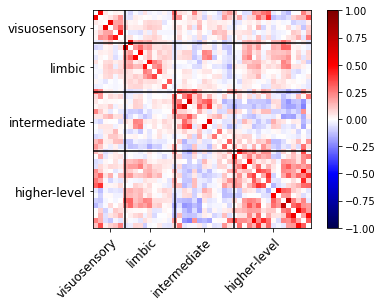

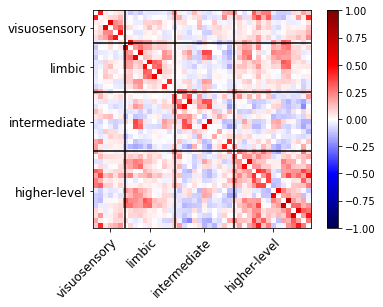

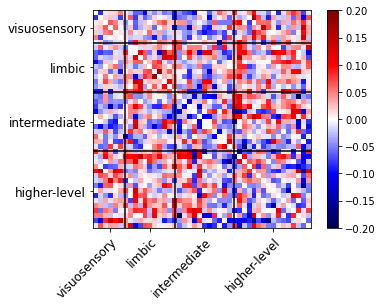

In [16]:
cud = pd.read_table("/Users/TienTong/Documents/rest/code/socialbrain/fcon/fcon_nosmooth_cud.txt", header=None)
cud_np=cud.to_numpy()
clims=(-1,1)
fig, ax = plt.subplots()
im = ax.imshow(cud_np,cmap='seismic',vmin=clims[0],vmax=clims[1],interpolation='none')
plt.colorbar(im)

for tr in transitions:
    ax.axhline(tr,0,44,color='k')
    ax.axvline(tr,0,44,color='k')

# alter how the tick marks are shown to plot network names
ax.set_xticks(centers)
ax.set_yticks(centers)
ax.set_xticklabels(networks,fontsize=12)
ax.set_yticklabels(networks,fontsize=12)
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')

plt.show()



hc = pd.read_table("/Users/TienTong/Documents/rest/code/socialbrain/fcon/fcon_nosmooth_hc.txt", header=None)
hc_np=hc.to_numpy()
clims=(-1,1)
fig, ax = plt.subplots()
im = ax.imshow(hc_np,cmap='seismic',vmin=clims[0],vmax=clims[1],interpolation='none')
plt.colorbar(im)

for tr in transitions:
    ax.axhline(tr,0,44,color='k')
    ax.axvline(tr,0,44,color='k')

# alter how the tick marks are shown to plot network names
ax.set_xticks(centers)
ax.set_yticks(centers)
ax.set_xticklabels(networks,fontsize=12)
ax.set_yticklabels(networks,fontsize=12)
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')

plt.show()




hcVScud = pd.read_table("/Users/TienTong/Documents/rest/code/socialbrain/fcon/fcon_nosmooth_hcVScud.txt", header=None)
hcVScud_np=hcVScud.to_numpy()
clims=(-0.2,0.2)
fig, ax = plt.subplots()
im = ax.imshow(hcVScud_np,cmap='seismic',vmin=clims[0],vmax=clims[1],interpolation='none')
plt.colorbar(im)

for tr in transitions:
    ax.axhline(tr,0,44,color='k')
    ax.axvline(tr,0,44,color='k')

# alter how the tick marks are shown to plot network names
ax.set_xticks(centers)
ax.set_yticks(centers)
ax.set_xticklabels(networks,fontsize=12)
ax.set_yticklabels(networks,fontsize=12)
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')

plt.show()

In [1]:
from nilearn.plotting import plot_connectome
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

social_coords = pd.read_csv("/Users/TienTong/Documents/rest/code/socialbrain/alcala-lopezetal2018_separatemidline_editedcoord.txt",
                            header=None, sep=' ')
social_coords = social_coords.iloc[:, 0:3]
social_coords.head()

/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


,0,1,2
0,-56,-39.0,2.0
1,54,-39.0,0.0
2,-42,-62.0,-16.0
3,43,-57.0,-19.0
4,-50,-66.0,5.0


In [2]:
network = pd.read_excel("/Users/TienTong/Documents/rest/brain_social_network/alcala-lopezetal2018_separatemidline_editedcoord.xlsx")
network.head()

,roi,x,y,z,index,subnetwork,subnetwork_name
0,pSTS_L,-56,-39,2,1,1,visuosensory
1,pSTS_R,54,-39,0,2,1,visuosensory
2,FG_L,-42,-62,-16,3,1,visuosensory
3,FG_R,43,-57,-19,4,1,visuosensory
4,MT/V5_L,-50,-66,5,5,1,visuosensory


In [3]:
nbs = pd.read_csv("~/Documents/rest/code/socialbrain/fcon/nbs_drugttest_thresh05_5000perm.txt",
                  header=None, sep='\t')
nbs.fillna(0, inplace=True)
nbs.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# assign color for each network
colors = []
random.seed(100000)
for i in range(4):
    colors.append('#%06X' % random.randint(0, 0xFFFFFF))
netname = np.unique(network['subnetwork_name'])

for i in range(len(netname)):
    network.loc[network['subnetwork_name']==netname[i], 'pythoncolor'] = colors[i]
node_color=list(network['pythoncolor'])
network.to_csv("~/Documents/rest/code/socialbrain/fcon/network_new.txt", sep='\t', header=True)


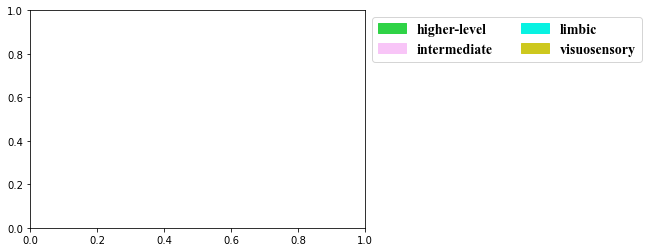

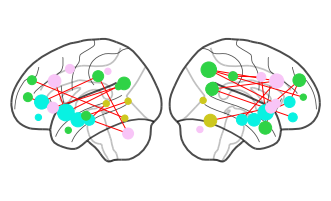

In [5]:
patch = []
for i in range(4):
    patch.append(mpatches.Patch(color=colors[i], label=netname[i]))
    
#del matplotlib.font_manager.weight_dict['roman']
#matplotlib.font_manager._rebuild()

# produce a legend for the objects in the other figure
font = matplotlib.font_manager.FontProperties(family='Times New Roman', size=14, weight='bold')
legend = plt.legend(prop=font, handles=patch, ncol=2, bbox_to_anchor=(1, 1), loc='upper left')


def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi=300, bbox_inches=bbox)

export_legend(legend)
plt.show()

plot_connectome(adjacency_matrix=nbs, node_coords=social_coords, 
                node_size=nbs.sum(axis=0)*40, 
                node_color=node_color, display_mode= 'lr', annotate=True, 
                edge_kwargs={"linewidth": 1, 'color': 'red'})

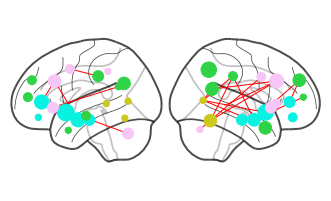

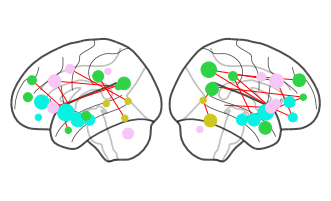

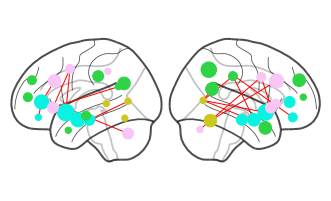

In [7]:

drug = pd.read_csv("~/Documents/rest/code/socialbrain/fcon/drug_nbs_mat.txt",
                  header=None, sep='\t')
trauma = pd.read_csv("~/Documents/rest/code/socialbrain/fcon/trauma_nbs_mat.txt",
                  header=None, sep='\t')
drug_trauma = pd.read_csv("/Users/TienTong/Documents/rest/code/socialbrain/fcon/drug_trauma_nbs_mat.txt",
                  header=None, sep='\t')

plot_connectome(adjacency_matrix=drug, node_coords=social_coords, 
                node_size=nbs.sum(axis=0)*40, 
                node_color=node_color, display_mode= 'lr', annotate=True, 
                edge_kwargs={"linewidth": 1, 'color': 'red'})
plot_connectome(adjacency_matrix=trauma, node_coords=social_coords, 
                node_size=nbs.sum(axis=0)*40, 
                node_color=node_color, display_mode= 'lr', annotate=True, 
                edge_kwargs={"linewidth": 1, 'color': 'red'})
plot_connectome(adjacency_matrix=drug_trauma, node_coords=social_coords, 
                node_size=nbs.sum(axis=0)*40, 
                node_color=node_color, display_mode= 'lr', annotate=True, 
                edge_kwargs={"linewidth": 1, 'color': 'red'})

## Motion Parameters Raw 

In [ ]:
%%bash

file=/Users/TienTong/Documents/dcm2bids/xnat_allsubjects.csv
# RUN FOR EVERYBODY
# subjects=(`awk -F "\"*,\"*" '{print $4}' $file | tr '\n' ' '`)

# RUN FOR SELECTED SUB
subjects=(sub-P22001 sub-P22002)

motion_raw_script_dir=/Users/TienTong/Documents/rest/code/motion_raw
motion_raw_script_dir_template=${motion_raw_script_dir}/motion_raw_TEMPLATE.sh

for i in ${!subjects[@]}; do
    id_long=${subjects[$i]}
    id_short=`echo ${subjects[$i]} | sed -e 's/sub-//g'`

    sed -e "s/SUBJECT/${id_long}/g" ${motion_raw_script_dir_template} > \
    ${motion_raw_script_dir}/motion_raw_${id_long}.sh
    
    bash ${motion_raw_script_dir}/motion_raw_${id_long}.sh
done


##############################################################################
# RUN FOR EVERYBODY
# motion_raw_script_dir=/Users/TienTong/Documents/rest/code/motion_raw
# ls ${motion_raw_script_dir}/*sub*.sh | xargs -I{} -P5 bash {} 


## Motion Parameters Preprocessed 

In [ ]:
%%bash

file=/Users/TienTong/Documents/dcm2bids/xnat_allsubjects.csv
# RUN FOR EVERYBODY
# subjects=(`awk -F "\"*,\"*" '{print $4}' $file | tr '\n' ' '`)

# RUN FOR SELECTED SUB
subjects=(sub-P22001 sub-P22002)

motion_meica_script_dir=/Users/TienTong/Documents/rest/code/motion_meica
motion_meica_script_dir_template=${motion_meica_script_dir}/motion_meica_TEMPLATE.sh

for i in ${!subjects[@]}; do
    id_long=${subjects[$i]}
    id_short=`echo ${subjects[$i]} | sed -e 's/sub-//g'`

    sed -e "s/SUBJECT/${id_long}/g" ${motion_meica_script_dir_template} > \
    ${motion_meica_script_dir}/motion_meica_${id_long}.sh
    
    bash ${motion_meica_script_dir}/motion_meica_${id_long}.sh
    
done


##############################################################################
# RUN FOR EVERYBODY
# motion_meica_script_dir=/Users/TienTong/Documents/rest/code/motion_meica
# ls ${motion_meica_script_dir}/*sub*.sh | xargs -I{} -P5 bash {} 


# Calculate tSNR of ME-ICA outputs

In [1]:
import glob
from nipype.algorithms.confounds import TSNR
import subprocess
import pandas as pd


in_file_list = ["/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_meica/sub-P22001/sub-P22001_task-rest_space-MNIN27_desc-T1cmedn_bold.nii",
                "/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_meica/sub-P22002/sub-P22002_task-rest_space-MNIN27_desc-T1cmedn_bold.nii"]
out_file_list = []

# create output files' names based on inputs
for i in in_file_list:
    out_file_list.append(i[:-4] + '_tsnr.nii')

# create tsnr nii files
for index in range(len(in_file_list)): 
    in_file=in_file_list[index]
    tsnr_file=out_file_list[index]

    tsnr = TSNR()
    tsnr.inputs.in_file = in_file
    tsnr.inputs.tsnr_file = tsnr_file
    res = tsnr.run() 
   

220128-13:48:41,710 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


In [2]:
tsnr_file_list = glob.glob("/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_meica/sub-*/sub-*_task-rest_space-MNIN27_desc-T1cmedn_bold_tsnr.nii")

id_long = []
TSNR_global_toappend = []

# get subject id    
for i in tsnr_file_list:
    id_long.append(pd.Series(i).str.split(pat="/")[0][6])

# calculate tsnr then append mean from each subject to df
for tsnr_file in tsnr_file_list:
    
    TSNR_global = subprocess.check_output('fslstats {0} -M'.format(tsnr_file), shell=True)
    TSNR_global_toappend.append(float(TSNR_global))# create tsnr df to later append actual value

tsnr_df = pd.DataFrame(id_long, columns =['id_long'])
tsnr_df['tSNR_global'] = TSNR_global_toappend
tsnr_df


,id_long,tSNR_global
0,sub-P18001,478.496979
1,sub-P18003,461.269093
2,sub-P18002,500.954756
3,sub-P18004,594.840714
4,sub-P18006,519.192749
...,...,...
69,sub-P21016,463.530636
70,sub-P21020,472.745955
71,sub-P21021,464.595791
72,sub-P22002,418.485167


In [3]:
tsnr_df.to_csv('/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_meica/tsnr_df.csv', index=False)

# NBS Predict

In [25]:
import glob
import pandas as pd


######################## cvs correlation matrix ########################
nosmooth_nobp = "/Volumes/BACHI-LAB/Team_Workspace/Tien/rest_social/nosmooth_nobp/"
# outpath = "/Users/TienTong/Documents/MATLAB/NBS-Predict/test_feb1/nosmooth_nobp/"
outpath = "/Users/TienTong/Documents/MATLAB/NBS/NBS1.2/test_feb1/nosmooth_nobp/"

file_list = glob.glob(nosmooth_nobp + "*.txt")
for file in file_list:
    sub = pd.read_csv(file, sep='\t', header=None)
    sub.fillna(1, inplace=True)
    outname = outpath + file.split('/')[-1][:-4] + '.txt'
    sub.to_csv(outname, header=False, index=False, sep=' ')  

########################## cvs network regions ########################
# network_file = "/Users/TienTong/Documents/rest/brain_social_network/alcala-lopezetal2018_separatemidline_editedcoord.xlsx"
# network = pd.read_excel(network_file)
# network_sim = network[['x', 'y', 'z', 'roi']]
# network_sim.to_csv('/Users/TienTong/Documents/MATLAB/NBS-Predict/test_feb1/network.csv', header=False, index=False)



In [1]:
import shutil

# shutil.copytree("/Users/TienTong/Documents/MATLAB/NBS-Predict/test_feb1/nosmooth_nobp/",
#                 "/Users/TienTong/Documents/MATLAB/NBS-Predict/test_feb1/nosmooth_nobp_N68/")

shutil.copytree("/Users/TienTong/Documents/MATLAB/NBS/NBS1.2/test_feb1/nosmooth_nobp/",
                "/Users/TienTong/Documents/MATLAB/NBS/NBS1.2/test_feb1/nosmooth_nobp_N68/")


'/Users/TienTong/Documents/MATLAB/NBS/NBS1.2/test_feb1/nosmooth_nobp_N68/'

In [4]:
import os

exclude_subjects = ['P19053',
                      'P18015',
                      'P19027',
                      'P19016',
                      'P19012',
                      'P19025']
n68 = "/Users/TienTong/Documents/MATLAB/NBS/NBS1.2/test_feb1/nosmooth_nobp_N68/"
for subject in exclude_subjects:
    os.remove(n68 + 'sub-' + subject + "_z.txt")